# SQLite Database and Python

SQLite is a C library that provides a lightweight disk-based database that doesn’t require a separate server process. The database is stored in a single file with a `.sqlite` or `.db` extension making it easily portable.

In [34]:
import sqlite3
import pandas as pd

pd.options.display.max_rows = 16

Specify database filename

In [35]:
database_filename = "midemo.db"

## Connect to sqlite database

In [36]:
conn = sqlite3.connect(database_filename)

## Create a cursor object

In [37]:
cursor = conn.cursor()

## Create a table

In [38]:
# Create a 'people' table from scratch. Delete if already exists. 
cursor.execute("DROP TABLE IF EXISTS people")
cursor.execute("""CREATE TABLE people
                   (statefips INTEGER DEFAULT 26,
                   x REAL,
                   y REAL,
                   quadkey TEXT,
                   race_type TEXT DEFAULT 'p') """)

## Inserting data into table

### Insert single row

In [39]:
cursor.execute("INSERT INTO people VALUES (26,-83.1,42.1,'0302','p')")

Similarly, you can insert using a `?` placeholder that points to a tuple (preferred method)

In [40]:
tuple_row = (26,-83.2,42.2,'0302','p')
cursor.execute("INSERT INTO people VALUES (?,?,?,?,?)", tuple_row)

Or use a named placeholder using a dictionary

In [41]:
dict_row = {'a':26,'b':-83.3,'c':80.4,'d':'0303','e':'p'}
cursor.execute("INSERT INTO people VALUES (:a,:b,:c,:d,:e)", dict_row)

### Insert multiple rows

To insert more than one row, you can use a list (or tuple) of tuples. Use the `executemany` method to insert more than one row

In [42]:
two_rows = [(27,-83.4,42.4,'0303','r1'),
             (28,-83.5,42.5,'0304','r2')]

cursor.executemany("INSERT INTO people VALUES (?,?,?,?,?)", two_rows)

### Insert data into only some columns

In [43]:
xyquad = [(-83.6,42.6,'0302'),(-83.7,42.7,'0302')]
cursor.executemany("INSERT INTO people (x,y,quadkey) VALUES (?,?,?)", xyquad)

Track total number of database rows that have been modified, inserted or deleted since connection has been open.

In [44]:
conn.total_changes

7

### Commit transaction to disk

In [45]:
conn.commit()

### Close cursor and database

In [46]:
# Close the cursor
cursor.close()
# Close the connection to the database
conn.close()

## Reading data from a table

Open up a database connection

In [47]:
conn = sqlite3.connect(database_filename)
c = conn.cursor()

Use `select` query to grab all the data from people table

In [48]:
c.execute("SELECT * FROM people")

Use `fetchall` to grab all the data from the query

In [49]:
results = c.fetchall()

Returns a list of tuples

In [50]:
for row in results:
    print(row)

(26, -83.1, 42.1, u'0302', u'p')
(26, -83.2, 42.2, u'0302', u'p')
(26, -83.3, 80.4, u'0303', u'p')
(27, -83.4, 42.4, u'0303', u'r1')
(28, -83.5, 42.5, u'0304', u'r2')
(26, -83.6, 42.6, u'0302', u'p')
(26, -83.7, 42.7, u'0302', u'p')


Create a dataframe from list of tuples

In [51]:
pd.DataFrame(results)

,0,1,2,3,4
0,26,-83.1,42.1,0302,p
1,26,-83.2,42.2,0302,p
2,26,-83.3,80.4,0303,p
3,27,-83.4,42.4,0303,r1
4,28,-83.5,42.5,0304,r2
5,26,-83.6,42.6,0302,p
6,26,-83.7,42.7,0302,p


## Reading metadata

To find out the name of tables in your database

In [52]:
# Add extra table to our database
c.execute("CREATE TABLE IF NOT EXISTS dogs (id INTEGER PRIMARY KEY AUTOINCREMENT)")
c.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = c.fetchall()
print(tables)

[(u'dogs',), (u'sqlite_sequence',), (u'people',)]


Grab metadata about table using `PRAGMA` SQL statement.  
Returns (column id, column name, data type, NOT NULL indicator, default value, primary key indicator)

In [53]:
c.execute("PRAGMA table_info(people)")
metadata = c.fetchall()
list(metadata)

[(0, u'statefips', u'INTEGER', 0, u'26', 0),
 (1, u'x', u'REAL', 0, None, 0),
 (2, u'y', u'REAL', 0, None, 0),
 (3, u'quadkey', u'TEXT', 0, None, 0),
 (4, u'race_type', u'TEXT', 0, u"'p'", 0)]

You can also use the cursor method `description` to get column names from the last query

In [54]:
c.description

(('cid', None, None, None, None, None, None),
 ('name', None, None, None, None, None, None),
 ('type', None, None, None, None, None, None),
 ('notnull', None, None, None, None, None, None),
 ('dflt_value', None, None, None, None, None, None),
 ('pk', None, None, None, None, None, None))

Use a list comprehension to extract names

In [55]:
[x[0] for x in c.description]

['cid', 'name', 'type', 'notnull', 'dflt_value', 'pk']

To reference columns by name instead of by index, use the `sqlite3.Row` class. It provides both index-based and case-insensitive name-based access.

In [61]:
# Set row_factory attribute
conn.row_factory = sqlite3.Row

# Need to create a new cursor object after setting row_factory
a = conn.cursor()
a.execute("SELECT * FROM people LIMIT 2")
results = a.fetchall()

# results is now a list of sqlite3.Row objects
list(results)

[<sqlite3.Row at 0x7d5a610>, <sqlite3.Row at 0x7d5a910>]

Access the keys (column names)

In [68]:
results[0].keys()

['statefips', 'x', 'y', 'quadkey', 'race_type']

Access data by index or name

In [65]:
for row in results:
    print(row[1], row["y"], row["quadkey"])

(-83.1, 42.1, u'0302')
(-83.2, 42.2, u'0302')


Close database connection

In [69]:
conn.close()

## Other Useful Commands

### `with` statement

You can use the `with` statement to `connect` to the database. It will automatically commit the transaction to disk for you but it will NOT `close` the connection.

In [27]:
with sqlite3.connect('midemo.db') as connection:
    c = connection.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS people
                       (statefips INTEGER DEFAULT 26,
                       x REAL,
                       y REAL,
                       quadkey TEXT,
                       race_type TEXT DEFAULT 'p')""" )
    two_rows = [(30,-84.0,43.0,'0303','r3'),
                 (31,-84.1,43.1,'0304','r4')]
    c.executemany("INSERT INTO people VALUES (?,?,?,?,?)", two_rows)
    
# Read data
c.execute("SELECT * FROM people")
c.fetchall()

[(26, -83.1, 42.1, u'0302', u'p'),
 (26, -83.2, 42.2, u'0302', u'p'),
 (26, -83.3, 80.4, u'0303', u'p'),
 (27, -83.4, 42.4, u'0303', u'r1'),
 (28, -83.5, 42.5, u'0304', u'r2'),
 (26, -83.6, 42.6, u'0302', u'p'),
 (26, -83.7, 42.7, u'0302', u'p'),
 (30, -84.0, 43.0, u'0303', u'r3'),
 (31, -84.1, 43.1, u'0304', u'r4')]

### `executescript`

You can also use `executescript` as an alternative to using multiple `execute` commands.

In [28]:
script = """
CREATE TABLE IF NOT EXISTS cats (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name NAME UNIQUE);
INSERT OR IGNORE INTO cats (name) VALUES ('Garfield');
INSERT OR IGNORE INTO cats (name) VALUES ('Grumpy Cat');
INSERT OR IGNORE INTO cats (name) VALUES ('Zarathustra');
INSERT OR IGNORE INTO cats (name) VALUES ('Cole and Marmalade');
"""
c.executescript(script)
connection.commit()

c.execute("SELECT * FROM cats")
c.fetchall()

[(1, u'Garfield'),
 (2, u'Grumpy Cat'),
 (3, u'Zarathustra'),
 (4, u'Cole and Marmalade')]

### SQL script file

You can also use a sql script file in combination with `executescript`.

In [29]:
with open('dogs.sql','r') as f:
    sqlquery = f.read()
c.executescript(sqlquery)
c.execute("SELECT * FROM dogs")
c.fetchall()

[(1, u'Lassie'),
 (2, u'Scooby Doo'),
 (3, u'Odie'),
 (4, u'Astro'),
 (5, u'Pluto'),
 (6, u'Snoopy')]

### Pandas SQL

Using `pandas` to read from a sqlite database

In [72]:
conn = sqlite3.connect(database_filename)
df = pd.read_sql_query("SELECT * FROM more_people", conn)
df

,index,statefips,x,y,quadkey,race_type
0,0,26,-83.1,42.1,0302,p
1,1,26,-83.2,42.2,0302,p
2,2,26,-83.3,80.4,0303,p
3,3,27,-83.4,42.4,0303,r1
4,4,28,-83.5,42.5,0304,r2
5,5,26,-83.6,42.6,0302,p
6,6,26,-83.7,42.7,0302,p


Using `pandas` to write a dataframe to a new table in a sqlite database.

In [71]:
df.to_sql("more_people", conn, if_exists="replace", index=True)
conn.close()

## Writing and Reading Images

You can also store and retrieve images in a sqlite database as a BLOB data type.

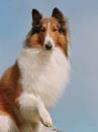

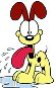

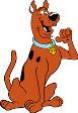

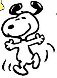

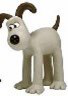

In [73]:
# import additional libraries
from PIL import Image
import os
import glob
from IPython.display import display

# grab list of jpg files
files = glob.glob(r'photos/*.jpg')

# open sqlite database in memory
conn = sqlite3.connect(':memory:')
c = conn.cursor()
c.execute('DROP TABLE IF EXISTS photos')
# create schema
c.execute('CREATE TABLE IF NOT EXISTS photos 
          (name TEXT, mode TEXT, x INTEGER, y INTEGER, bytedata BLOB)')

# loop through each file and store it in the database
names = []
for dog in files:
    img = Image.open(dog)
    name = os.path.splitext(dog)
    names.append(name[0])
    c.execute('INSERT INTO photos (name,mode,x,y,bytedata) VALUES (?,?,?,?,?)',
              (name[0], img.mode, img.size[0], img.size[1], buffer(img.tobytes())) )
    img.close()

# retrieve images by name
for dog in names:
    c.execute('SELECT * FROM photos WHERE name=?', (dog,) )
    row = c.fetchone()
    display(Image.frombytes(row[1],(row[2],row[3]),row[4]))
    
conn.close()

## References

Official Documentation  
https://www.sqlite.org

SQLite Tutorial  
https://www.tutorialspoint.com/sqlite/


## Software Version for Jupyter Notebook

In [33]:
# you only need to do this once
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


C:\Users\caoa\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\IPython\core\magics\extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [34]:
%load_ext version_information
%version_information pandas, sqlite3, PIL

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.3
OS Windows 7 6.1.7601 SP1
pandas 0.18.0
sqlite3 The 'sqlite3' distribution was not found and is required by the application
PIL The 'PIL' distribution was not found and is required by the application
Wed Mar 16 14:11:48 2016 Eastern Daylight Time

In [35]:
sqlite3.version

'2.6.0'

In [36]:
import PIL
PIL.VERSION

'1.1.7'